#  Data Collection

In [ ]:
'''
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATASETS
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE CELL.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote
from urllib.error import HTTPError
from zipfile import ZipFile

CHUNK_SIZE = 40960
DATASET_MAPPING = 'kermany2018:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F17839%2F23942%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20220609%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20220609T011526Z%26X-Goog-Expires%3D259199%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8577e633726fb18ef5a4c5ab12be326fc0d245c8a1655938f7f0c4e147b0172d46bbfaa5ea31f3dd30df42423209f8d2eb48cb245934302b39de9c0d7bf80bf94f1a9a10c7a226adde651ee328388416bbc032febe98256cecc4b50a4052aa1e0daca1986649624ef579a095e1624172f5bc0e32f5e0f6a92ae81bb12916609b100866e2a59fa4742e752894d0161c5d7be103145a134d765211c23d1c7c7dfe8708702674e63353cb77a2318ebc59913621c1ff401195e61a344b7ec1f780942e4fa0d92fbd0f8705fcf112979e195f9a082ecb909ce1d85b7e7198b4d43183b66a6e0f881939cccfd3c8ff52531f6e92ca0dd3c8726b0a21317b47d172b276'
KAGGLE_INPUT_PATH='/home/kaggle/input'
KAGGLE_INPUT_SYMLINK='/kaggle'

os.makedirs(KAGGLE_INPUT_PATH, 777)
os.symlink(KAGGLE_INPUT_PATH, os.path.join('..', 'input'), target_is_directory=True)
os.makedirs(KAGGLE_INPUT_SYMLINK)
os.symlink(KAGGLE_INPUT_PATH, os.path.join(KAGGLE_INPUT_SYMLINK, 'input'), target_is_directory=True)

for dataset_mapping in DATASET_MAPPING.split(','):
    directory, download_url_encoded = dataset_mapping.split(':')
    download_url = unquote(download_url_encoded)
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as zipfileres, NamedTemporaryFile() as tfile:
            total_length = zipfileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes zipped')
            dl = 0
            data = zipfileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = zipfileres.read(CHUNK_SIZE)
            print(f'\nUnzipping {directory}')
            with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue
print('Dataset import complete.')
'''

# VGG16 
https://www.kaggle.com/code/whitedragon1107/vgg16-transfer-learning-pytorch

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.hub import load_state_dict_from_url
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics
plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


## Dataset loader
The dataset is divided in three categories: training, validation and test.

The first one will be, obviously, used for trainig; the validation set will be used to measure the model performance during training and the test set will be used to evaluate our model performance once the training has finished.

Note: These three sets should all contain different images.

Loading this dataset with pytorch is really easy using ImageFolder as the labels are specified by the folders names.

In [13]:
data_dir = '/home/kaggle/input/kermany2018/OCT2017 '
TRAIN = 'train'
VAL = 'val'
TEST = 'test'
# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally. 
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4,
        shuffle=True, num_workers=8
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 83484 images under train
Loaded 32 images under val
Loaded 968 images under test
Classes: 
['CNV', 'DME', 'DRUSEN', 'NORMAL']


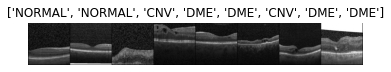

In [6]:
#Some utility function to visualize the dataset and the model's predictions

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [7]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training
    
    # Set model for evaluation
    vgg.train(False)
    vgg.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
        
        outputs = vgg(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    vgg.train(mode=was_training) # Revert model back to original training state

In [58]:
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    true_label = [] 
    pred_label = [] 
    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)
    class_label= ['CNV', 'DME', 'DRUSEN', 'NORMAL']
    for i, data in enumerate(dataloaders[TEST]):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        vgg.train(False)
        vgg.eval()
        inputs, labels = data

        true_label.extend(labels.view(-1).detach().cpu().numpy())
        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        pred_label.extend(preds.view(-1).detach().cpu().numpy())
        
        loss_test += loss.item()
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test / dataset_sizes[TEST]
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)
    print(sklearn.metrics.classification_report(true_label ,  pred_label, target_names =class_label ))
    
    ## confusion matrix 
    train_cm=confusion_matrix(pred_label,true_label)

    import seaborn as sns

    ax = sns.heatmap(train_cm, annot=True, cmap='Blues')
    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['DME','DRUSEN','CNV','NORMAL'])
    ax.yaxis.set_ticklabels(['DME','DRUSEN','CNV','NORMAL'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

## Model creation
The VGG-16 is able to classify 1000 different labels; we just need 4 instead. In order to do that we are going replace the last fully connected layer of the model with a new one with 4 output features instead of 1000.

In PyTorch, we can access the VGG-16 classifier with model.classifier, which is an 6-layer array. We will replace the last entry.

We can also disable training for the convolutional layers setting requre_grad = False, as we will only train the fully connected classifier.

In [64]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16_bn(pretrained=True)

state_dict = torch.hub.load_state_dict_from_url('https://download.pytorch.org/models/vgg16_bn-6c64b313.pth')

#vgg16.load_state_dict(torch.load("../input/vgg16bn/vgg16_bn.pth"))
vgg16.load_state_dict(state_dict)
print(vgg16.classifier[6].out_features) # 1000 


# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg16)

1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128

The output above is the summary of our model. Notice how the last layer has 4 output features as we specified.

In [65]:
# If you want to train the model for more than 2 epochs, set this to True after the first run
'''
resume_training = True

if resume_training:
    print("Loading pretrained model..")
    vgg16.load_state_dict(torch.load('../input/vgg16-transfer-learning-pytorch/VGG16_v2-OCT_Retina.pt'))
    print("Loaded!")
'''
resume_training = False
if resume_training:
    print("Loading pretrained model..")
    vgg16.load_state_dict(state_dict)
    print("Loaded!")

We will also define our loss function (cross entropy) and the optimizer.

The learning rate will start at 0.001 and a StepLR object will decrese it by a factor of 0.1 every 7 epochs (not really needed here as we're training for 2 epochs only)

For further details refer to https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [66]:
if use_gpu:
    vgg16.cuda() #.cuda() will move everything to the GPU side
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Model evaluation and visualization (before training)
Let's see how our model performs before any training

Test before training
Evaluating model
----------
Test batch 0/242

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Test batch 200/242
Evaluation completed in 0m 10s
Avg loss (test): 0.3509
Avg acc (test): 0.1508
----------
              precision    recall  f1-score   support

         CNV       0.13      0.39      0.20       242
         DME       0.20      0.17      0.18       242
      DRUSEN       0.00      0.00      0.00       242
      NORMAL       0.17      0.05      0.07       242

    accuracy                           0.15       968
   macro avg       0.13      0.15      0.11       968
weighted avg       0.13      0.15      0.11       968



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


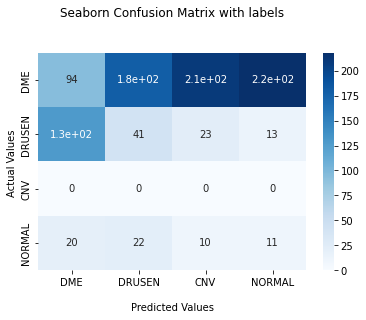

In [67]:
print("Test before training")
eval_model(vgg16, criterion)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


Ground truth:


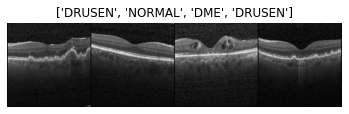

Prediction:


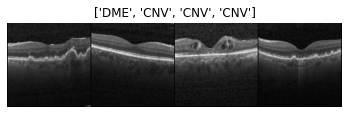

Ground truth:


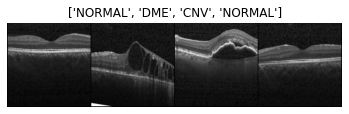

Prediction:


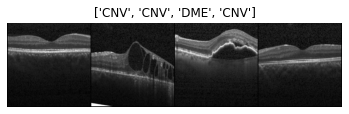

In [68]:
visualize_model(vgg16) #test before training

Not really great results. Let's see if it can do better after training

## Training
What follows is pretty standard pytorch code for training.

For every epoch we iterate over all the training batches, compute the loss , and adjust the network weights with loss.backward() and optimizer.step(). Then we evaluate the performance over the validaton set. At the end of every epoch we print the network progress (loss and accuracy). The accuracy will tell us how many predictions were correct.

As we said before, transfer learning can work on smaller dataset too, so for every epoch we only iterate over half the trainig dataset (worth noting that it won't exactly be half of it over the entire training, as the data is shuffled, but it will almost certainly be a subset)

In [73]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=10,size=128):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[VAL])
    train_loss_values = []
    train_acc_values = []
    val_acc_values = []   
    val_loss_values =[]        
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        vgg.train(True)
        
        for i, data in enumerate(dataloaders[TRAIN]):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches /size), end='', flush=True)
                
            # Use half training dataset
            if i >= train_batches/size:
                break
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train * size / dataset_sizes[TRAIN]
        avg_acc = acc_train * size / dataset_sizes[TRAIN]
        
        vgg.train(False)
        vgg.eval()
            
        for i, data in enumerate(dataloaders[VAL]):
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss_val += loss.item()
            acc_val += torch.sum(preds == labels.data)
            
            
            
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / dataset_sizes[VAL]
        avg_acc_val = acc_val / dataset_sizes[VAL]
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        
        #train_loss_values.append(avg_loss.cpu().data.numpy().argmax())
        #val_loss_values.append(avg_loss_val.cpu().data.numpy().argmax())
        #train_acc_values.append(avg_acc.cpu().data.numpy().argmax())
        #val_acc_values.append(avg_acc_val.cpu().data.numpy().argmax())        
        
        train_loss_values.append(float(avg_loss))
        val_loss_values.append(float(avg_loss_val))
        train_acc_values.append(float(avg_acc))
        val_acc_values.append(float(avg_acc_val))        


        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    
    epochs = range(len(train_acc_values))
    plt.figure(figsize=(12,12))

    plt.plot(epochs, train_acc_values, 'r', label = 'Training accuracy')
    plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
    plt.title('Training & validation accuracy')
    plt.legend()

    plt.figure(figsize = (12,12))

    plt.plot(epochs, train_acc_values, 'r', label = 'Training Loss')
    plt.plot(epochs, val_loss_values, 'b', label = 'Validation Loss')
    plt.title('Training $ validation loss')
    plt.legend()
    plt.show()
    
    vgg.load_state_dict(best_model_wts)
    return vgg

## trainning (epoch = 30)

Epoch 0/30
----------
Training batch 100/163.0546875
Validation batch 0/8

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Epoch 0 result: 
Avg loss (train): 0.2537
Avg acc (train): 0.6286
Avg loss (val): 0.1744
Avg acc (val): 0.7188
----------

Epoch 1/30
----------
Training batch 100/163.0546875
Validation batch 0/8
Epoch 1 result: 
Avg loss (train): 0.1920
Avg acc (train): 0.7222
Avg loss (val): 0.0775
Avg acc (val): 0.9375
----------

Epoch 2/30
----------
Training batch 100/163.0546875
Validation batch 0/8
Epoch 2 result: 
Avg loss (train): 0.1746
Avg acc (train): 0.7482
Avg loss (val): 0.0560
Avg acc (val): 0.8438
----------

Epoch 3/30
----------
Training batch 100/163.0546875
Validation batch 0/8
Epoch 3 result: 
Avg loss (train): 0.1609
Avg acc (train): 0.7620
Avg loss (val): 0.0323
Avg acc (val): 0.9688
----------

Epoch 4/30
----------
Training batch 100/163.0546875
Validation batch 0/8
Epoch 4 result: 
Avg loss (train): 0.1326
Avg acc (train): 0.8034
Avg loss (val): 0.0255
Avg acc (val): 0.9688
----------

Epoch 5/30
----------
Training batch 100/163.0546875
Validation batch 0/8
Epoch 5 result

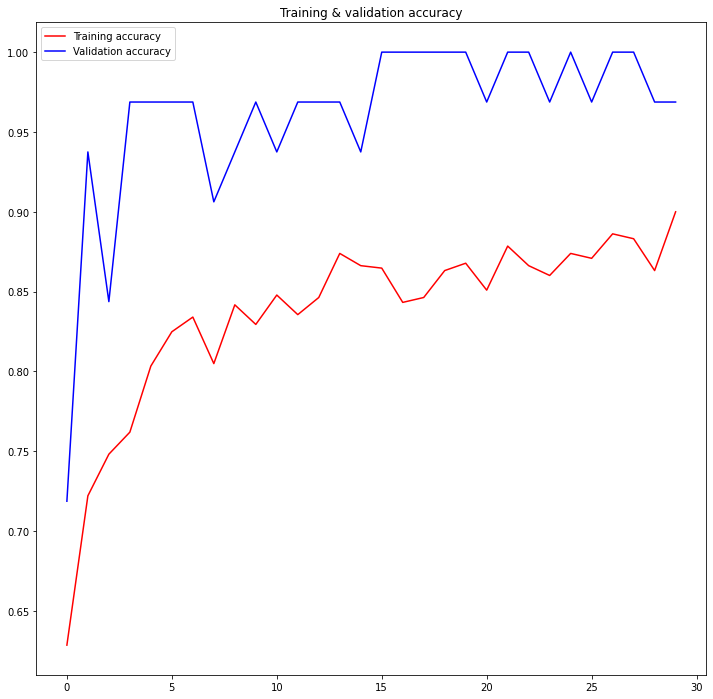

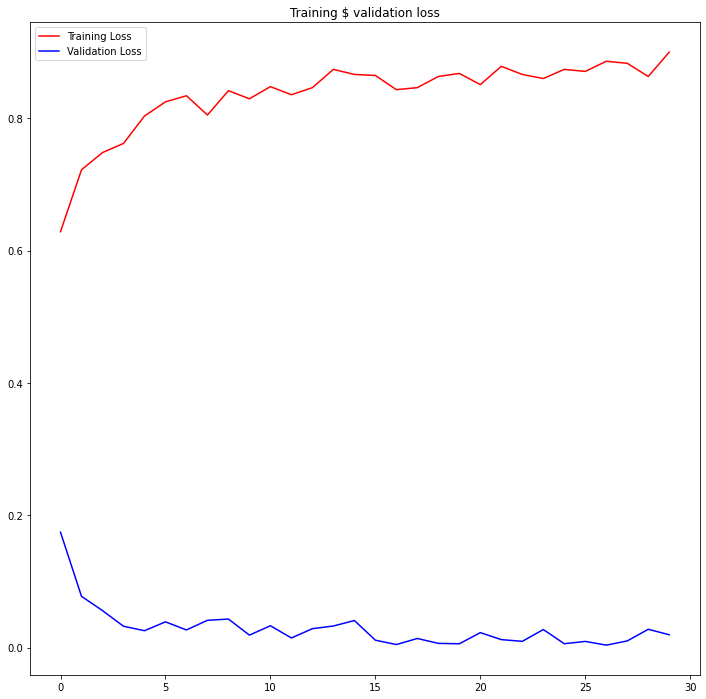

In [70]:
vgg16 = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)
#torch.save(vgg16.state_dict(), '../input/vgg16-transfer-learning-pytorch/VGG16_v2-OCT_Retina4.pt')

## Model evaluation and visualization (after training)
Let's evaluate our model again after 2 epochs of training

Evaluating model
----------
Test batch 0/242

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Test batch 200/242
Evaluation completed in 0m 10s
Avg loss (test): 0.0099
Avg acc (test): 0.9917
----------
              precision    recall  f1-score   support

         CNV       0.98      1.00      0.99       242
         DME       1.00      0.98      0.99       242
      DRUSEN       1.00      0.99      0.99       242
      NORMAL       1.00      1.00      1.00       242

    accuracy                           0.99       968
   macro avg       0.99      0.99      0.99       968
weighted avg       0.99      0.99      0.99       968



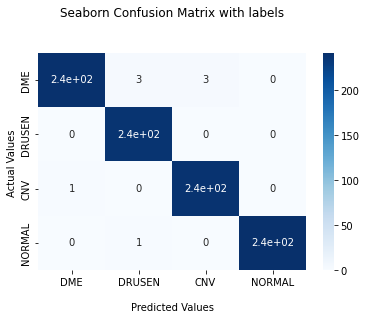

In [71]:
eval_model(vgg16, criterion)

Ground truth:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


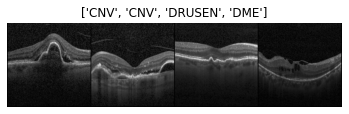

Prediction:


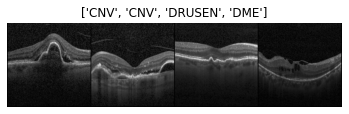

Ground truth:


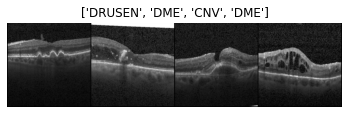

Prediction:


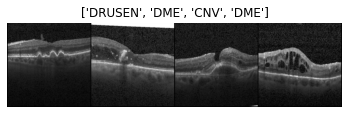

Ground truth:


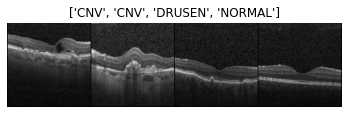

Prediction:


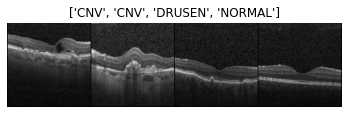

Ground truth:


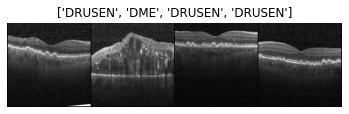

Prediction:


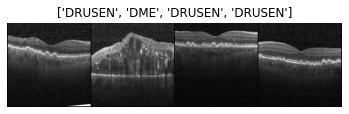

Ground truth:


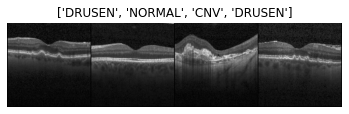

Prediction:


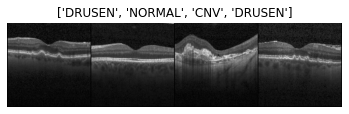

Ground truth:


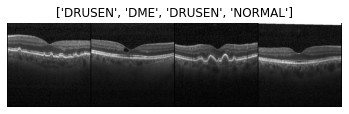

Prediction:


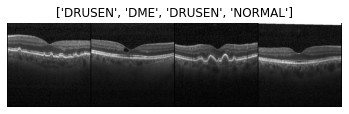

Ground truth:


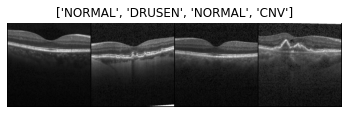

Prediction:


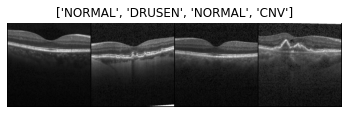

Ground truth:


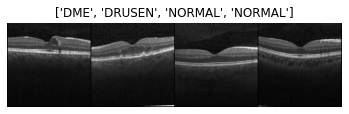

Prediction:


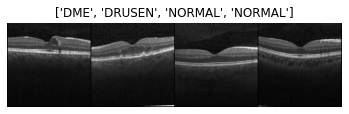

In [72]:
visualize_model(vgg16, num_images=32)

## change trainning size

Epoch 0/2
----------
Training batch 10400/10435.5
Validation batch 0/8

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Epoch 0 result: 
Avg loss (train): 0.0849
Avg acc (train): 0.8787
Avg loss (val): 0.0109
Avg acc (val): 1.0000
----------

Epoch 1/2
----------
Training batch 10400/10435.5
Validation batch 0/8
Epoch 1 result: 
Avg loss (train): 0.0737
Avg acc (train): 0.8942
Avg loss (val): 0.0090
Avg acc (val): 1.0000
----------


Training completed in 44m 4s
Best acc: 1.0000


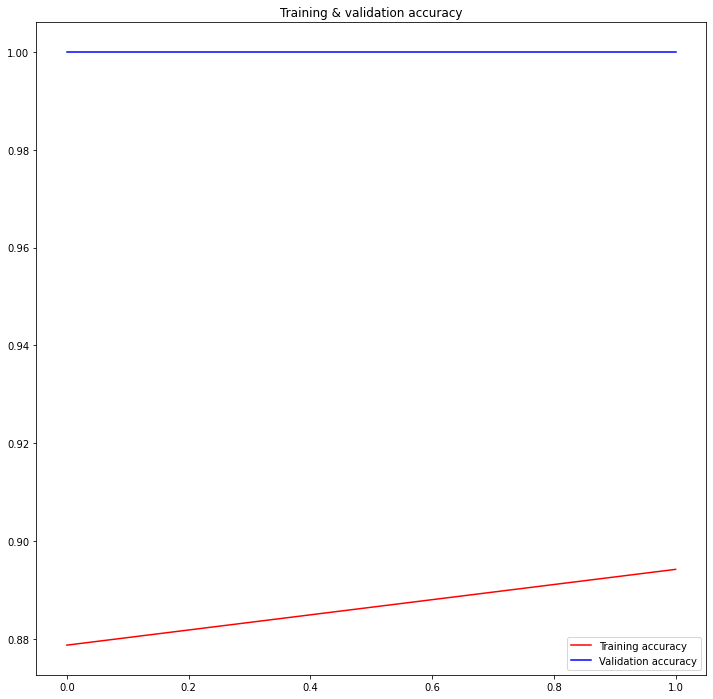

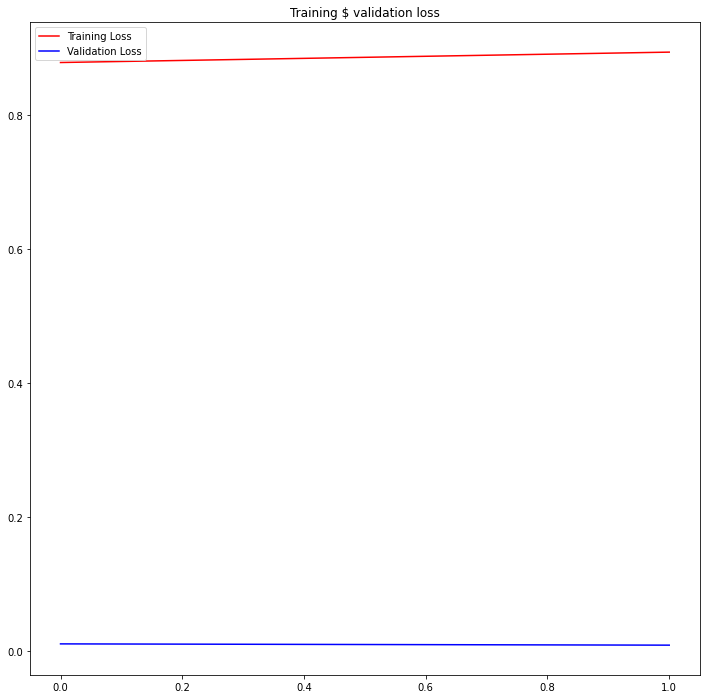

In [74]:
vgg16 = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2,size=2)

Evaluating model
----------
Test batch 0/242

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Test batch 200/242
Evaluation completed in 0m 10s
Avg loss (test): 0.0138
Avg acc (test): 0.9886
----------
              precision    recall  f1-score   support

         CNV       0.96      1.00      0.98       242
         DME       1.00      1.00      1.00       242
      DRUSEN       1.00      0.96      0.98       242
      NORMAL       1.00      1.00      1.00       242

    accuracy                           0.99       968
   macro avg       0.99      0.99      0.99       968
weighted avg       0.99      0.99      0.99       968



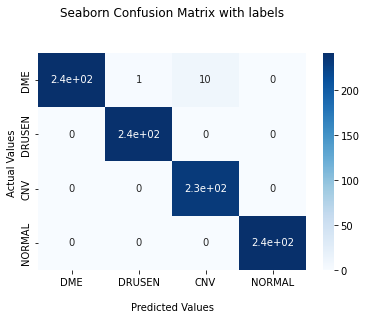

In [75]:
eval_model(vgg16, criterion)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


Ground truth:


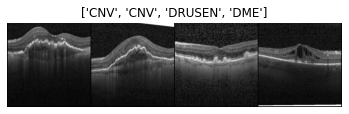

Prediction:


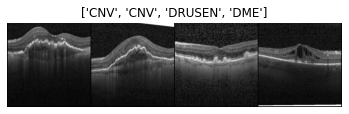

Ground truth:


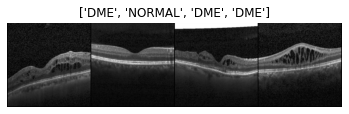

Prediction:


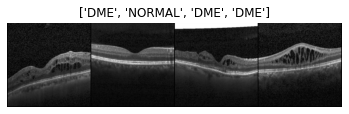

Ground truth:


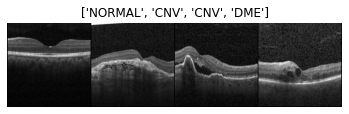

Prediction:


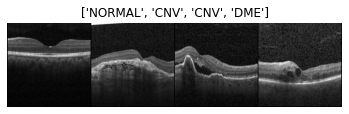

Ground truth:


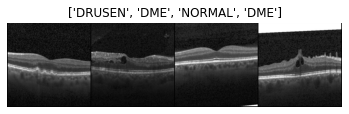

Prediction:


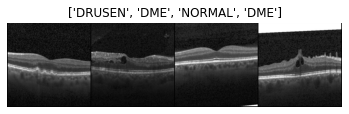

Ground truth:


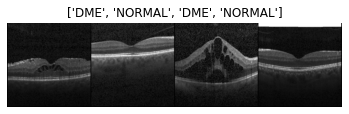

Prediction:


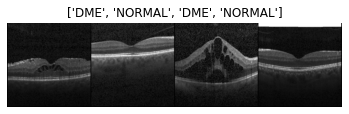

Ground truth:


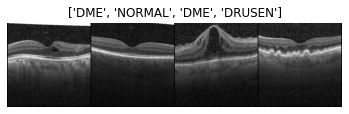

Prediction:


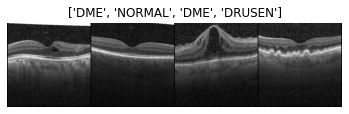

Ground truth:


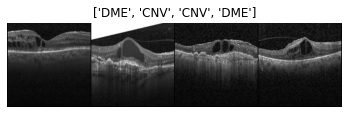

Prediction:


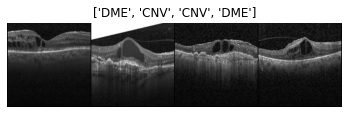

Ground truth:


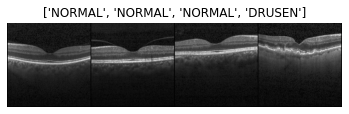

Prediction:


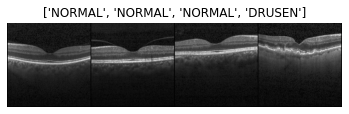

In [76]:
visualize_model(vgg16, num_images=32)

# Feature extraction- SVM | RandomForeset | Logistic regression

In [20]:
from zipfile import ZipFile
import os 
import pandas as pd
import numpy as np 
import cv2
from PIL import Image
import sys
import gc
import skimage
from skimage.transform import resize
from skimage.io import imread
import glob
import tqdm
from  skimage import feature
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics

np.set_printoptions(threshold=sys.maxsize)
os.chdir('/home/kaggle/input/kermany2018/OCT2017 ')


def df_create(loc):
    ## get file in train folder
    list_file_type = os.listdir(loc)
    location  = loc

    df = []
    file_name = []
    img_type = [] 

    for type in list_file_type:
        list_file=os.listdir(f'{location}/{type}')
        for file in list_file:
            file_name.append(file)
            img_type.append(type)

    df = pd.DataFrame(list(zip(file_name,img_type)),columns=["img_name","img_type"])
    return df

In [24]:
## collect all file in train/val/test
df = df_create("train")
dfval = df_create("val")
dftest = df_create("test")
#combine_df('test',dftest)

In [25]:
#(canny-humoment) : https://www.kaggle.com/code/kambingbersayaphitam/canny-humoment-svm/notebook
#(Local Binary Pattern) : https://medium.com/@burhanahmeed/image-recognition-with-svm-and-local-binary-pattern-289cc19ba7fe
#(GLCM) : https://medium.com/mlearning-ai/color-shape-and-texture-feature-extraction-using-opencv-cb1feb2dbd73
#(skimage套件參考) :  https://blog.csdn.net/lyxleft/article/details/102904909


def CANNY_FUN(dir,num):
    import cv2
    imageSize =150
    combine_all = [] 
    print(num)
    img_gray=cv2.imread(dir+'/'+num.split("-")[0]+'/'+num, cv2.IMREAD_COLOR)
    ## resize
    img_gray=cv2.resize(img_gray,(150,150))

    ##　Histogram - V(10 bins)
    V = cv2.cvtColor(img_gray,cv2.COLOR_BGR2HSV)[:,:,2]
    V_mean  = np.mean(V)
    V_var  = np.var(V)
    V_med  = np.median(V)
    hist_V, _ = np.histogram(V, bins=10)
    combine_all.append(V_mean)
    combine_all.append(V_var)
    combine_all.append(V_med)
    
    ##　Histogram - grayscale(10 bins)
    img_gray = cv2.cvtColor(img_gray,cv2.COLOR_BGR2GRAY)
    gray_mean  = np.mean(img_gray)
    gray_var  = np.var(img_gray)
    gray_med  = np.median(img_gray)
    hist_img_gray, _ = np.histogram(img_gray, bins=10)
    combine_all.append(gray_mean)
    combine_all.append(gray_var)
    combine_all.append(gray_med)

    combine_all.extend(hist_V)
    combine_all.extend(hist_img_gray)    

    ##　Local Binary Pattern
    lbp = feature.local_binary_pattern(img_gray,8,1, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(),bins=np.arange(0, 11), range=(0,10))
    hist = hist.astype("float")                         
    hist /= (hist.sum())
    combine_all.extend(np.array(hist))
    
    ##　GLCM
    graycom = feature.graycomatrix(img_gray, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256)

    # Find the GLCM properties
    contrast = feature.graycoprops(graycom, 'contrast')
    dissimilarity = feature.graycoprops(graycom, 'dissimilarity')
    homogeneity = feature.graycoprops(graycom, 'homogeneity')
    energy = feature.graycoprops(graycom, 'energy')
    correlation = feature.graycoprops(graycom, 'correlation')
    ASM = feature.graycoprops(graycom, 'ASM')
    combine_all.extend(contrast[0])
    combine_all.extend(dissimilarity[0])
    combine_all.extend(homogeneity[0])
    combine_all.extend(energy[0])
    combine_all.extend(correlation[0])
    combine_all.extend(ASM[0])


    ## canny+hu moment
    img_gray = cv2.GaussianBlur(img_gray,(7,7),0)
    canny = cv2.Canny(img_gray, 30, 130)
    canny_hu=cv2.HuMoments(cv2.moments(canny )).flatten()
    combine_all.extend(canny_hu)
    combine_all = np.asarray(combine_all)

    return combine_all




def combine_df(dir,data):
    canny_hu_all=[CANNY_FUN(dir,x) for x in data['img_name']]
    col = []
    stat=[x+y for x in ["V","gray"] for y in ["_mean","_var","_med"]]
    hist=[x+str(y) for x in ["hist_V","hist_gray"] for y in list(range(1,11))]
    lbp=["LBP_"+str(y) for y in list(range(1,11))]
    glcm=["glcm_"+x+str(y) for x in ["contrast","dissimilarity","homogeneity","energy","correlation","ASM"] for y in list(range(1,5))]
    canny=['Canny_hu1','Canny_hu2','Canny_hu3','Canny_hu4','Canny_hu5','Canny_hu6','Canny_hu7']
    col.extend(stat)
    col.extend(hist)
    col.extend(lbp)
    col.extend(glcm)
    col.extend(canny)
    canny_hu_all = pd.DataFrame(canny_hu_all,columns=col)
    data = pd.concat([data.reset_index(drop=True), canny_hu_all], axis=1)
    return(data)

In [26]:
#img = cv2.imread("./train/NORMAL/NORMAL-1384-1.jpeg", cv2.IMREAD_GRAYSCALE)
#local_binary_pattern(img, 8,1.0,method='var')

CANNY_FUN('train','NORMAL-1384-1.jpeg')

NORMAL-1384-1.jpeg


array([ 4.28106667e+01,  1.34696584e+03,  3.50000000e+01,  4.28106667e+01,
        1.34696584e+03,  3.50000000e+01,  8.19700000e+03,  7.38600000e+03,
        4.04300000e+03,  1.31000000e+03,  6.78000000e+02,  3.18000000e+02,
        2.95000000e+02,  1.82000000e+02,  7.30000000e+01,  1.80000000e+01,
        8.19700000e+03,  7.38600000e+03,  4.04300000e+03,  1.31000000e+03,
        6.78000000e+02,  3.18000000e+02,  2.95000000e+02,  1.82000000e+02,
        7.30000000e+01,  1.80000000e+01,  1.37155556e-01,  1.06133333e-01,
        5.05333333e-02,  5.57777778e-02,  6.94666667e-02,  5.91111111e-02,
        5.22666667e-02,  1.00977778e-01,  1.49733333e-01,  2.18844444e-01,
        3.06411946e+02,  5.62543489e+02,  4.70563669e+02,  4.57187424e+02,
        1.25347204e+01,  1.57421738e+01,  1.45223266e+01,  1.46351065e+01,
        1.00126891e-01,  8.62474900e-02,  9.16565489e-02,  8.99943566e-02,
        1.71753812e-02,  1.65581337e-02,  1.71233178e-02,  1.67730056e-02,
        8.86290630e-01,  

In [27]:
combine_df('test',dftest)

DME-3064922-1.jpeg
DME-7870558-2.jpeg
DME-4079773-1.jpeg
DME-8889771-2.jpeg
DME-4117019-1.jpeg
DME-6314020-1.jpeg
DME-9504297-1.jpeg
DME-8729675-2.jpeg
DME-4244491-1.jpeg
DME-8472707-1.jpeg
DME-8729675-1.jpeg
DME-8525575-3.jpeg
DME-778975-2.jpeg
DME-5434248-1.jpeg
DME-4940184-1.jpeg
DME-8615417-2.jpeg
DME-8525575-8.jpeg
DME-7934335-1.jpeg
DME-7614088-1.jpeg
DME-7793366-1.jpeg
DME-30521-6.jpeg
DME-1274315-1.jpeg
DME-3810791-1.jpeg
DME-8000885-1.jpeg
DME-1081406-1.jpeg
DME-8426419-2.jpeg
DME-70266-2.jpeg
DME-70266-1.jpeg
DME-5843591-1.jpeg
DME-30521-5.jpeg
DME-7780589-1.jpeg
DME-8908847-1.jpeg
DME-1102486-2.jpeg
DME-9488073-1.jpeg
DME-8177380-3.jpeg
DME-7558688-1.jpeg
DME-5497895-1.jpeg
DME-7983936-1.jpeg
DME-4336607-1.jpeg
DME-7837305-4.jpeg
DME-8602716-1.jpeg
DME-1102486-3.jpeg
DME-4732091-1.jpeg
DME-1479682-1.jpeg
DME-7870558-4.jpeg
DME-8021831-1.jpeg
DME-7907461-1.jpeg
DME-462675-1.jpeg
DME-7650134-2.jpeg
DME-2105194-1.jpeg
DME-8861620-3.jpeg
DME-7837305-2.jpeg
DME-8200056-2.jpeg
DME

,img_name,img_type,V_mean,V_var,V_med,gray_mean,gray_var,gray_med,hist_V1,hist_V2,...,glcm_ASM2,glcm_ASM3,glcm_ASM4,Canny_hu1,Canny_hu2,Canny_hu3,Canny_hu4,Canny_hu5,Canny_hu6,Canny_hu7
0,DME-3064922-1.jpeg,DME,44.191200,2628.081576,28.0,44.191200,2628.081576,28.0,10459.0,6206.0,...,0.001245,0.001266,0.001245,0.008180,0.000023,1.597477e-08,1.075640e-08,-1.386773e-16,9.163497e-12,2.548471e-17
1,DME-7870558-2.jpeg,DME,54.176267,4958.640397,27.0,54.176267,4958.640397,27.0,10770.0,5875.0,...,0.006469,0.006479,0.006482,0.008503,0.000011,2.743939e-08,3.502956e-08,1.812708e-16,-4.747507e-11,1.070788e-15
2,DME-4079773-1.jpeg,DME,52.477600,4231.618120,26.0,52.477600,4231.618120,26.0,10917.0,5393.0,...,0.002841,0.002809,0.002837,0.013359,0.000056,3.196004e-07,2.631035e-09,5.560557e-17,1.060996e-11,5.223869e-17
3,DME-8889771-2.jpeg,DME,35.742933,2067.226983,21.0,35.742933,2067.226983,21.0,13112.0,5268.0,...,0.000901,0.000942,0.000915,0.010158,0.000012,1.676918e-07,9.805248e-08,1.204256e-14,-1.704038e-10,-3.613940e-15
4,DME-4117019-1.jpeg,DME,49.609289,3649.718234,27.0,49.609289,3649.718234,27.0,10531.0,5876.0,...,0.002154,0.002231,0.002204,0.010827,0.000022,2.120484e-07,6.923979e-08,6.885795e-15,1.679117e-11,4.793163e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,NORMAL-3308307-1.jpeg,NORMAL,59.081289,4469.525881,34.0,59.081289,4469.525881,34.0,8011.0,7639.0,...,0.004269,0.004314,0.004304,0.020394,0.000007,1.514857e-06,6.571310e-07,5.936864e-13,-1.745103e-09,2.782029e-13
964,NORMAL-3244919-1.jpeg,NORMAL,34.831778,1918.608101,20.0,34.831778,1918.608101,20.0,13906.0,4112.0,...,0.001051,0.001096,0.001054,0.018711,0.000079,1.200276e-06,1.774139e-07,8.172107e-14,1.520470e-10,4.927398e-15
965,NORMAL-2377429-1.jpeg,NORMAL,46.210756,2655.279760,29.0,46.210756,2655.279760,29.0,9748.0,7270.0,...,0.000709,0.000727,0.000715,0.018212,0.000017,1.225670e-06,3.116705e-07,1.497421e-13,-9.042361e-10,1.211806e-13
966,NORMAL-697826-1.jpeg,NORMAL,43.528844,1933.418235,31.0,43.528844,1933.418235,31.0,9041.0,7743.0,...,0.000564,0.000589,0.000575,0.017183,0.000034,3.603325e-07,1.756053e-07,3.405092e-14,8.301591e-10,2.813895e-14


## SIFT + KMEANS


code : https://blog.csdn.net/weixin_42486554/article/details/103732613  
reference : https://ieeexplore.ieee.org/document/8466432

In [28]:
def SIFT_FUN(img_gray):
    #img_gray=cv2.imread(dir+'\\'+num.split("-")[0]+'\\'+num, cv2.IMREAD_GRAYSCALE)
    img_gray = cv2.GaussianBlur(img_gray,(7,7),0)
    sift =  cv2.SIFT_create()
    kp = sift.detect(img_gray,None)
    kp, des = sift.compute(img_gray, kp)
    return des

#計算詞袋
def learnVocabulary(features):
    wordCnt = 50
    #criteria表示迭代停止的模式   eps---精度0.1，max_iter---滿足超過最大迭代次數20
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 0.1)
    #得到k-means的初始中心點
    flags = cv2.KMEANS_RANDOM_CENTERS
    #標籤，中心 = kmeans(輸入數據、K,預設標籤，停止條件、重複次數、初始中心點
    compactness, labels, centers = cv2.kmeans(features, wordCnt, None,criteria, 20, flags)
    return centers

#計算特徵向量
def calcFeatVec(features, centers):
    featVec = np.zeros((1, 50))
    for i in range(0, features.shape[0]):
        #第i張的特徵點
        fi = features[i]
        diffMat = np.tile(fi, (50, 1)) - centers
        #axis=1按行求和，即求特徵到每个中心點的距離
        sqSum = (diffMat**2).sum(axis=1)
        dist = sqSum**0.5
        #升序排序
        sortedIndices = dist.argsort()
        #取出最小的距離，即找到最近的中心點
        idx = sortedIndices[0]
        #該中心點對應+1
        featVec[0][idx] += 1
    return featVec

#建立詞袋
def build_center(dir):
    cate=[dir+'/'+x for x in os.listdir(dir) if os.path.isdir(dir+'/'+x)]
    features = np.float32([]).reshape(0,128)#存放訓練集圖片的特徵
    for idx,folder in enumerate(cate):
        use_pic_list=list(set([x.split("-")[0]+'-'+x.split("-")[1]+'-'+'1.jpeg' for x in glob.glob(folder+'/*.jpeg')]))

        for im in (use_pic_list):
            print(im)
            img=cv2.imread(im, cv2.IMREAD_GRAYSCALE)
            #獲取圖片特徵sift特徵點
            img_f = SIFT_FUN(img)
            #特徵點加入訓練數據
            features = np.append(features, img_f, axis=0)
    #訓練集的詞袋
    centers = learnVocabulary(features)
    #將詞袋保存
    filename = "/home/kaggle/input/svm/svm_centers.npy"
    np.save(filename, centers)
    print('詞袋:',centers.shape)

#計算訓練集詞袋特徵向量
def cal_vec(dir):
    centers = np.load("/home/kaggle/input/svm/svm_centers.npy")
    data_vec = np.float32([]).reshape(0, 50)#存放訓練集詞袋特徵
    labels = np.float32([])
    cate=[dir+'/'+x for x in os.listdir(dir) if os.path.isdir(dir+'/'+x)]
    for idx,folder in enumerate(cate):
        
        for im in tqdm(glob.glob(folder+'/*.jpeg')):
            img=cv2.imread(im, cv2.IMREAD_GRAYSCALE)
            
            #獲取sift
            img_f = SIFT_FUN(img)
            img_vec = calcFeatVec(img_f, centers)
            data_vec = np.append(data_vec,img_vec,axis=0)
            labels = np.append(labels,idx)
    print('data_vec:',data_vec.shape)
    print('image features vector done!')
    return data_vec,labels

In [ ]:
build_center("train")

In [29]:
def all_feature(dir,data):
    data = combine_df(dir,data)
    print("canny_done")
    dat,lab=cal_vec(dir)
    data['label']=pd.Series(lab)
    dat = pd.DataFrame(dat,columns= ["SIFT_"+str(y) for y in list(range(1,51))])
    data  = pd.concat([data.reset_index(drop=True), dat ], axis=1)
    
    data.to_csv("/home/kaggle/input/data/df_"+dir+".csv")
    return data

In [ ]:
dfval = df_create("val")
dfval = all_feature("val",dfval)

In [ ]:
dftest = df_create("test")
dftest = all_feature("test",dftest)

In [ ]:
df = df_create("train")
df = all_feature("train",df)

In [ ]:
df.to_csv("/home/kaggle/input/data/df_"+"train"+".csv")

## Rescaling 

(normalization)https://scikit-learn.org/stable/modules/preprocessing.html  
(PCA)https://zhuanlan.zhihu.com/p/66845940


In [30]:
df = pd.read_csv("/home/kaggle/input/data/df_"+"train"+".csv")
dftest = pd.read_csv("/home/kaggle/input/data/df_"+"test"+".csv")
dfval = pd.read_csv("/home/kaggle/input/data/df_"+"val"+".csv")

In [31]:
col = []
stat=[x+y for x in ["V","gray"] for y in ["_mean","_var","_med"]]
hist=[x+str(y) for x in ["hist_V","hist_gray"] for y in list(range(1,11))]
lbp=["LBP_"+str(y) for y in list(range(1,11))]
glcm=["glcm_"+x+str(y) for x in ["contrast","dissimilarity","homogeneity","energy","correlation","ASM"] for y in list(range(1,5))]
canny=['Canny_hu1','Canny_hu2','Canny_hu3','Canny_hu4','Canny_hu5','Canny_hu6','Canny_hu7']
sift=["SIFT_"+str(y) for y in list(range(1,51))]

col.extend(stat)
col.extend(hist)
col.extend(lbp)
col.extend(glcm)
col.extend(canny)
col.extend(sift)

In [32]:
## get need columns
x_train = df[col]
x_test = dftest[col]
x_val = dfval[col]

y_train = df["label"]
y_test = dftest["label"]
y_val = dfval["label"]

In [33]:
## normalization 
scaler = preprocessing.StandardScaler().fit(x_train)


x_train = pd.DataFrame(scaler.transform(x_train),columns=col)
x_test = pd.DataFrame(scaler.transform(x_test),columns=col)
x_val = pd.DataFrame(scaler.transform(x_val),columns=col)

In [34]:
x_train.head(5)

,V_mean,V_var,V_med,gray_mean,gray_var,gray_med,hist_V1,hist_V2,hist_V3,hist_V4,...,SIFT_41,SIFT_42,SIFT_43,SIFT_44,SIFT_45,SIFT_46,SIFT_47,SIFT_48,SIFT_49,SIFT_50
0,-0.761335,-0.882817,-0.468077,-0.761335,-0.882817,-0.468077,0.543686,-0.159853,0.037018,0.194641,...,-0.211426,-0.391753,-0.092443,-0.856548,-0.531893,-0.576092,-0.262461,-0.852002,-0.209401,-0.257682
1,1.400951,0.217377,2.600770,1.400951,0.217377,2.600770,-2.086329,-0.428100,2.032128,5.478737,...,-0.211426,-0.951041,-0.221326,-0.856548,-1.004830,-0.751121,-0.107823,-1.326483,-0.791522,-0.053835
2,-0.466036,-0.672179,-0.243527,-0.466036,-0.672179,-0.243527,0.175994,0.308490,-0.170806,-0.215139,...,-0.211426,-0.578183,-0.135404,-0.522251,-0.768361,-0.926150,-0.262461,-0.140280,-0.403442,-0.176143
3,-0.089328,-0.314054,0.205572,-0.089328,-0.314054,0.205572,-0.492567,1.421350,0.189769,-0.536975,...,-0.211426,0.353964,-0.221326,-0.772974,0.413981,0.124024,-0.223801,-0.140280,-0.209401,-0.216912
4,-0.253984,-0.504999,-0.093827,-0.253984,-0.504999,-0.093827,0.122728,-0.631822,0.260429,0.903802,...,-0.211426,-0.578183,-0.221326,1.399960,-0.295424,-0.313548,-0.262461,-0.377521,-0.403442,-0.257682


## PCA

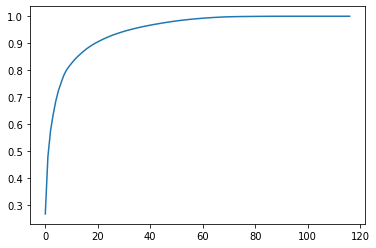

In [35]:
pca = PCA(n_components=x_train.shape[1])
pca.fit(x_train)
#pca.explained_variance_ratio_

plt.plot([i for i in range(x_train.shape[1])],
        [np.sum(pca.explained_variance_ratio_[:i+1]) for i in range(x_train.shape[1])])

In [36]:
cumulative_exp_ratio=np.array([np.sum(pca.explained_variance_ratio_[:i+1]) for i in range(x_train.shape[1])])
print("n_component we need to use : ",np.sum(cumulative_exp_ratio<=0.95))

n_component we need to use :  33


In [37]:
pca = PCA(0.95)
pca.fit(x_train)


x_train_reduction = pca.transform(x_train)
x_test_reduction = pca.transform(x_test)
x_val_reduction = pca.transform(x_val)

In [38]:
print('train shape:', x_train_reduction.shape)
print('test shape:', x_test_reduction.shape)

train shape: (83484, 34)
test shape: (968, 34)


## Smote for balance

In [39]:
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score

## label encoding
le = preprocessing.LabelEncoder()
le.fit(['DME','DRUSEN','CNV','NORMAL'])

## smote for balance data 
oversample = SMOTE()
x_train_smote, y_train_smote = oversample.fit_resample(x_train_reduction, y_train)

## confusion matrix and report

In [40]:
def confusion_matrix_and_report(pre,true):
    ## classification_report
    print(sklearn.metrics.classification_report(pre,true, target_names= ['DME','DRUSEN','CNV','NORMAL']))

    ## confusion matrix 
    train_cm=confusion_matrix(pre,true)

    import seaborn as sns

    ax = sns.heatmap(train_cm, annot=True, cmap='Blues')
    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['DME','DRUSEN','CNV','NORMAL'])
    ax.yaxis.set_ticklabels(['DME','DRUSEN','CNV','NORMAL'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

## SVC
Parameters:
- C: 限制模型的複雜度，防止過度擬合。
- max_iter: 最大迭代次數，預設1000。  

https://stackoverflow.com/questions/31681373/making-svm-run-faster-in-python/32025662#32025662  
https://colab.research.google.com/github/andy6804tw/2021-13th-ironman/blob/main/11.SVM/11.1.SVM(Classification-iris).ipynb#scrollTo=264otQUu1r2A

In [ ]:
'''
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

model = OneVsRestClassifier(LinearSVC(C=1, max_iter=10000))
svm_model= model.fit(x_train, y_train )

pred_svm = svm_model.predict(x_train)
confusion_matrix_and_report(pred_svm,y_train) 
'''

#### Linear SVM

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_it

Bagging SVC 25.400688648223877 0.679135868834834
              precision    recall  f1-score   support

         DME       0.59      0.64      0.62     34544
      DRUSEN       0.67      0.67      0.67     37104
         CNV       0.69      0.68      0.68     37626
      NORMAL       0.77      0.72      0.75     39546

    accuracy                           0.68    148820
   macro avg       0.68      0.68      0.68    148820
weighted avg       0.68      0.68      0.68    148820



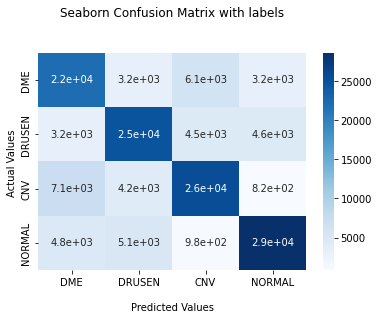

In [50]:
import time
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

n_estimators = 80
start = time.time()
clf = OneVsRestClassifier(BaggingClassifier(SVC(kernel='linear', max_iter=10000),random_state=1, max_samples=1.0 / n_estimators, n_estimators=n_estimators,bootstrap=False,n_jobs=-1))
clf.fit(x_train_smote, y_train_smote)
end = time.time()
print("Bagging SVC", end - start, clf.score(x_train_smote, y_train_smote))
## train
proba = clf.predict(x_train_smote)
confusion_matrix_and_report(proba,y_train_smote) 

              precision    recall  f1-score   support

         DME       0.57      0.75      0.64       183
      DRUSEN       0.82      0.82      0.82       243
         CNV       0.83      0.71      0.77       284
      NORMAL       0.91      0.86      0.88       258

    accuracy                           0.78       968
   macro avg       0.78      0.78      0.78       968
weighted avg       0.80      0.78      0.79       968



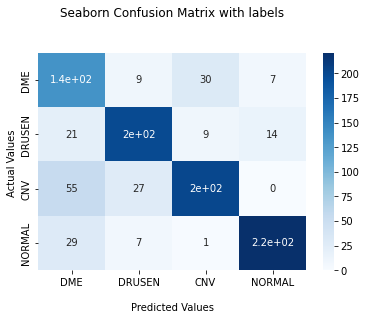

In [52]:
## test
proba = clf.predict(x_test_reduction)
confusion_matrix_and_report(proba,y_test) 

#### Kernel SVM

Bagging SVC 15.35655665397644 0.7175581239080768
              precision    recall  f1-score   support

         DME       0.63      0.72      0.67     32247
      DRUSEN       0.68      0.71      0.69     35841
         CNV       0.74      0.71      0.72     38717
      NORMAL       0.83      0.73      0.78     42015

    accuracy                           0.72    148820
   macro avg       0.72      0.72      0.72    148820
weighted avg       0.72      0.72      0.72    148820



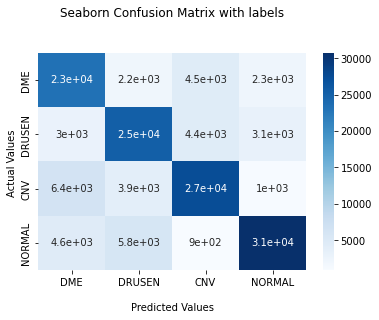

In [53]:
import time
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

n_estimators = 80
start = time.time()
clf = OneVsRestClassifier(BaggingClassifier(SVC(kernel='rbf', gamma=0.01, C=1, max_iter=10000),random_state=1, max_samples=1.0 / n_estimators, n_estimators=n_estimators,bootstrap=False,n_jobs=-1))
clf.fit(x_train_smote, y_train_smote)
end = time.time()
print("Bagging SVC", end - start, clf.score(x_train_smote, y_train_smote))
proba = clf.predict(x_train_smote)
confusion_matrix_and_report(proba,y_train_smote) 

              precision    recall  f1-score   support

         DME       0.58      0.85      0.69       164
      DRUSEN       0.84      0.84      0.84       242
         CNV       0.88      0.74      0.80       286
      NORMAL       0.96      0.84      0.90       276

    accuracy                           0.82       968
   macro avg       0.82      0.82      0.81       968
weighted avg       0.84      0.82      0.82       968



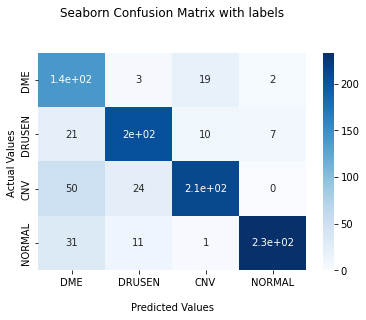

In [54]:
## test
proba = clf.predict(x_test_reduction)
confusion_matrix_and_report(proba,y_test) 

## Random forest 

(random forest)https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier  
(smote)https://machinelearningmastery.com/multi-class-imbalanced-classification/  
(confusion matrix)https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report

              precision    recall  f1-score   support

         DME       0.71      0.74      0.73     35802
      DRUSEN       0.73      0.75      0.74     36290
         CNV       0.76      0.79      0.77     35927
      NORMAL       0.82      0.75      0.78     40801

    accuracy                           0.76    148820
   macro avg       0.76      0.76      0.75    148820
weighted avg       0.76      0.76      0.76    148820



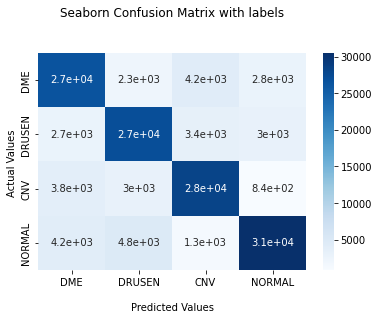

In [41]:
clf_tree = RandomForestClassifier(max_depth=10, random_state=3,min_samples_split=5,bootstrap=True,n_jobs=-1,n_estimators=200)
clf_tree.fit(x_train_smote,y_train_smote)

## train
train_predic = clf_tree.predict(x_train_smote)
confusion_matrix_and_report(train_predic,y_train_smote) 

              precision    recall  f1-score   support

         DME       0.60      0.81      0.69       179
      DRUSEN       0.79      0.85      0.82       227
         CNV       0.86      0.75      0.80       279
      NORMAL       0.95      0.81      0.88       283

    accuracy                           0.80       968
   macro avg       0.80      0.80      0.80       968
weighted avg       0.82      0.80      0.81       968



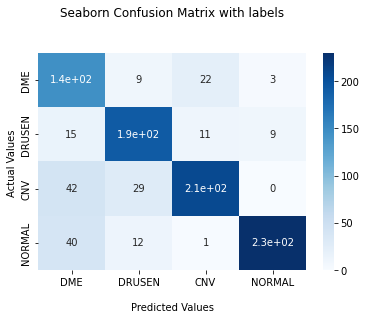

In [42]:
## test

Random_test_pred=clf_tree.predict(x_test_reduction)
confusion_matrix_and_report(Random_test_pred,y_test)

## Multinomial Logistic Regression

(Multinomial Logistic Regression)https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html

In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

...
# define the multinomial logistic regression model with a default penalty
log_model=LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=0.3)
# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(log_model,x_train_smote,y_train_smote, scoring='accuracy', cv=cv, n_jobs=-1)
# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Mean Accuracy: 0.682 (0.004)


              precision    recall  f1-score   support

         DME       0.62      0.64      0.63     35985
      DRUSEN       0.68      0.66      0.67     38338
         CNV       0.67      0.69      0.68     35851
      NORMAL       0.77      0.74      0.75     38646

    accuracy                           0.68    148820
   macro avg       0.68      0.68      0.68    148820
weighted avg       0.68      0.68      0.68    148820



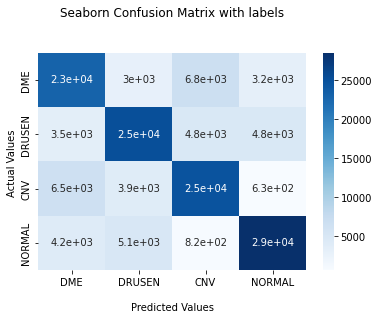

In [44]:
from sklearn.linear_model import LogisticRegressionCV

##many-vs-many
clf = LogisticRegressionCV(cv=20,Cs=10, random_state=3,n_jobs=-1,multi_class= "multinomial").fit(x_train_smote,y_train_smote)
logit_train_pred=clf.predict(x_train_smote)
confusion_matrix_and_report(logit_train_pred,y_train_smote)

              precision    recall  f1-score   support

         DME       0.60      0.72      0.65       200
      DRUSEN       0.83      0.82      0.82       246
         CNV       0.81      0.72      0.76       269
      NORMAL       0.91      0.87      0.89       253

    accuracy                           0.79       968
   macro avg       0.79      0.78      0.78       968
weighted avg       0.80      0.79      0.79       968



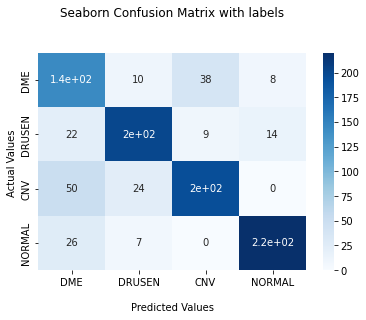

In [45]:
## test result
logit_test_pred=clf.predict(x_test_reduction)
confusion_matrix_and_report(logit_test_pred,y_test)